In [1]:
%load_ext autoreload
%autoreload 2
%load_ext line_profiler
%load_ext memory_profiler

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re


sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
module = fc.eightb.preselection.ranked_quadh

data = ObjIter([Tree(module.JetHT_Data_UL_List)])

# signal = ObjIter([Tree(fn) for fn in module.signal_list])
# signal = ObjIter([Tree(module.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
# signal_asym = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(module.QCD_B_List)])
# qcd_asym = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])
ttbar = ObjIter([Tree(module.TTJets)])
# ttbar = ObjIter([])
# qcd = ObjIter([])

100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


# Event Selection
## - Trigger applied | HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5
## - Required at least 8 jets to pass preselection
## - Preselections: Jet $P_{T} > 20$ [GeV], Jet $|\eta| < 2.5$, Tight Jet ID
## - Top 8 Btagged jets selected
## - Jets are paired into di-jets using the QuadHRanker Algorithm
## - Di-Jets are paired into Quad-Jets using by minimizing the mass difference between pairs

In [3]:
bkg = qcd + ttbar
bkg.reweight(2.3)
bkg.set_systematics([0.2])

[None, None]

# MC Reweighting
## MC Background normalization needs to be corrected to match data normalization
## A rough correction of 2.3x is applied along with a 20\% uncertainty

In [4]:
(data + bkg).apply(lambda t : build_collection(t, 'H\dY\d', 'higgs', ptordered=True))

[None, None, None]

In [5]:
del varinfo.higgs_m

# Blind Data to the Loose Btag Multiplity [2, 4] band

In [15]:
blind_mask = lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag <=  4)

# 4 Di-Jet mass spectrums 
## Di-Jets ordered by $P_{T}$

100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


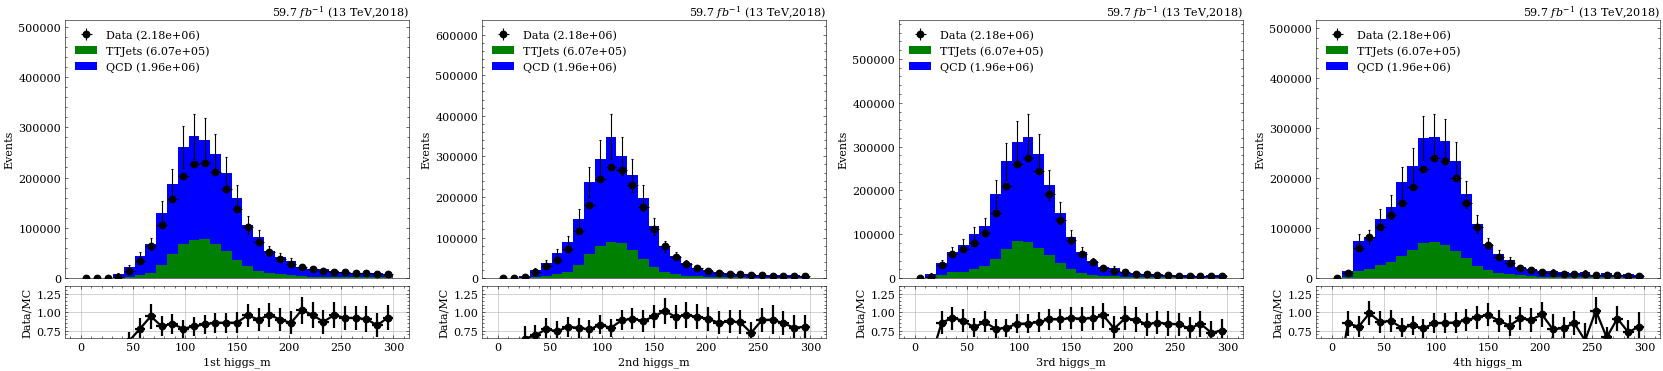

In [16]:
study.quick(
    data+bkg, legend=True,
    # efficiency=True,
    masks=blind_mask,
    varlist=[ f'higgs_m[:,{i}]' for i in range(4) ],
    binlist=[(0,300,30)]*4,
    dim=-1,

    **study.datamc
)

# Higgs Mass CR using Machine learning techniques
## Using the BDT Classifier trained on MC bkg and signal
## Evaluate the Data/MC agreement

# Boosted Decision Tree Classifier

In [17]:
bdt_classifier = BDTClassifier.load('bdt_resonant_mass_classifier')

In [18]:
(data+bkg).apply(lambda t : t.extend(
    bdt_higgs_m=bdt_classifier.predict_tree(t)
))

[None, None, None]

100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


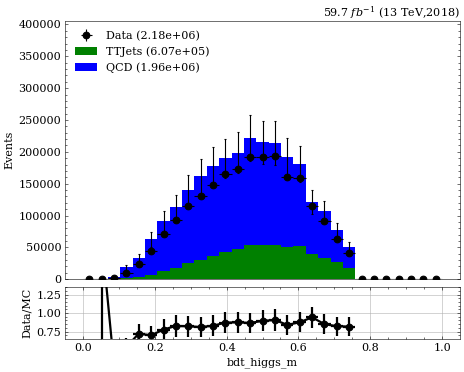

In [19]:
varinfo.bdt_higgs_m = dict(bins=(0,1,30))
study.quick(
    data+bkg, legend=True,
    masks=blind_mask,
    varlist=['bdt_higgs_m'],
    **study.datamc,
)

# Di-Jet masses as a function of bdt score

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


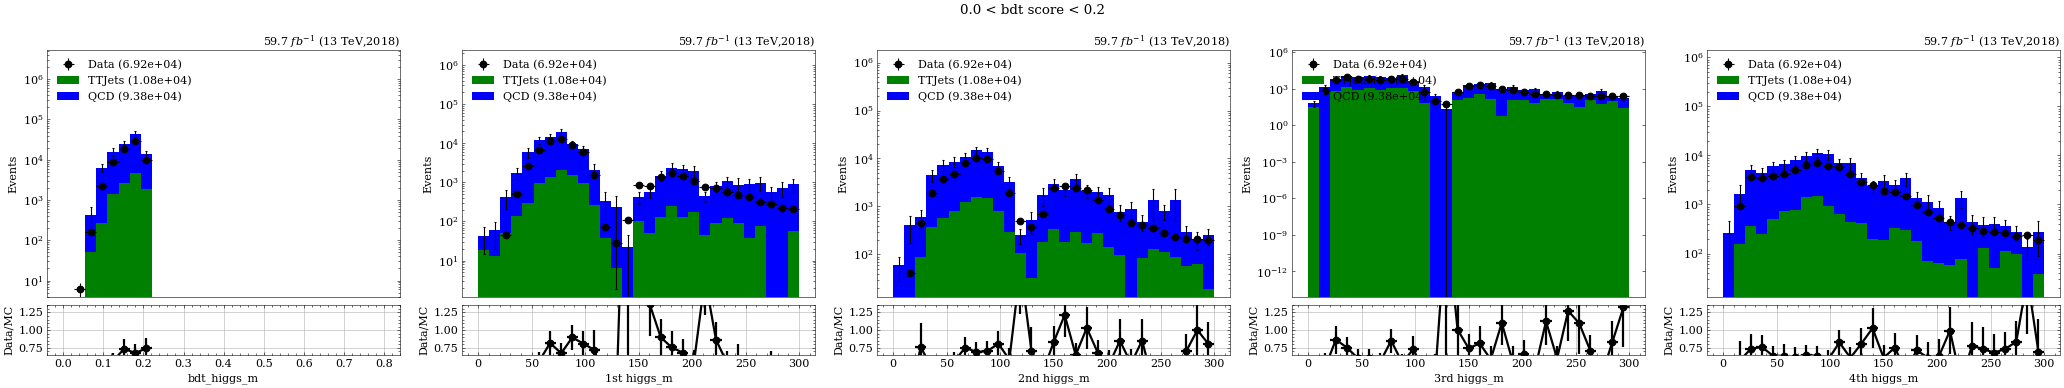

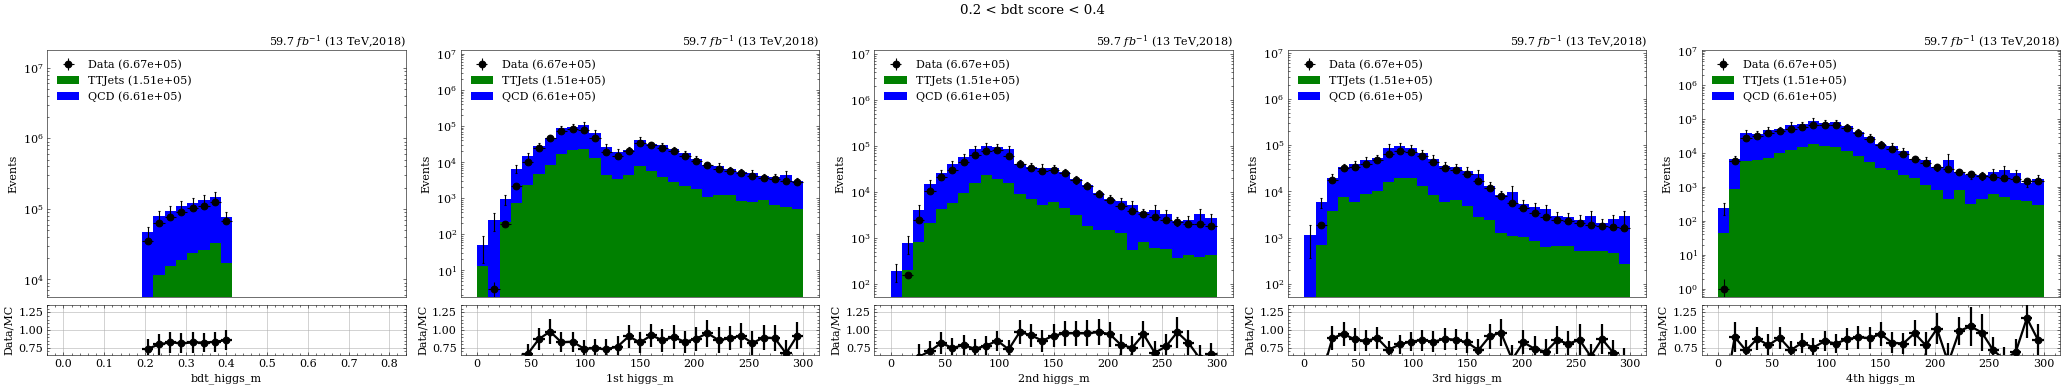

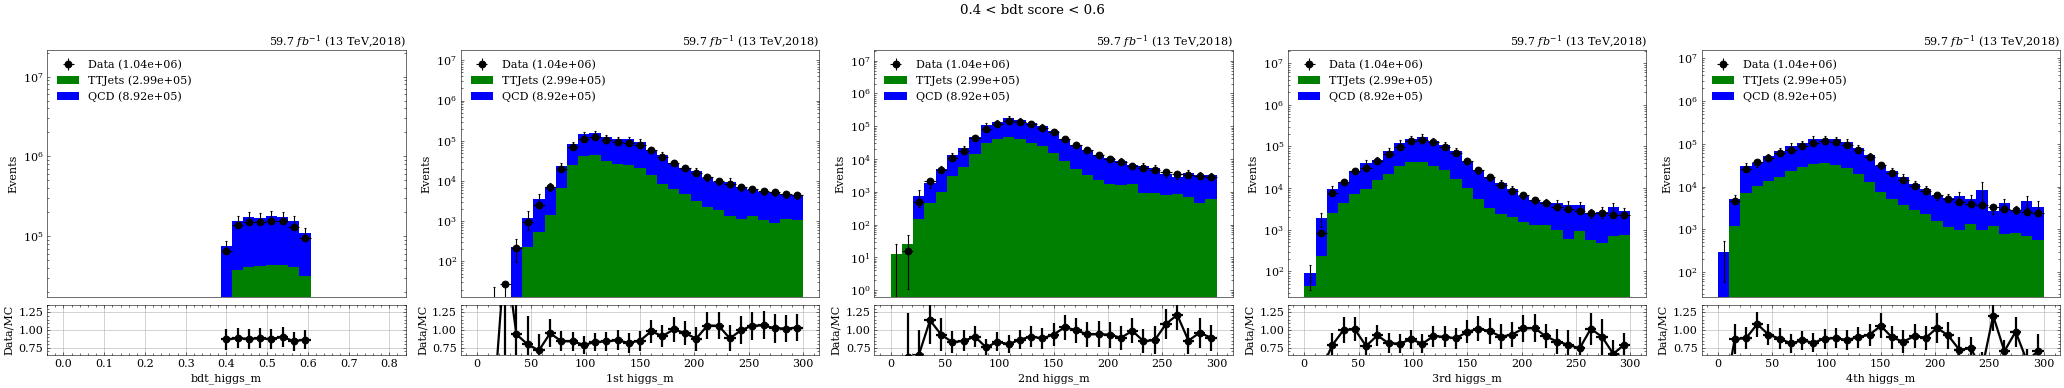

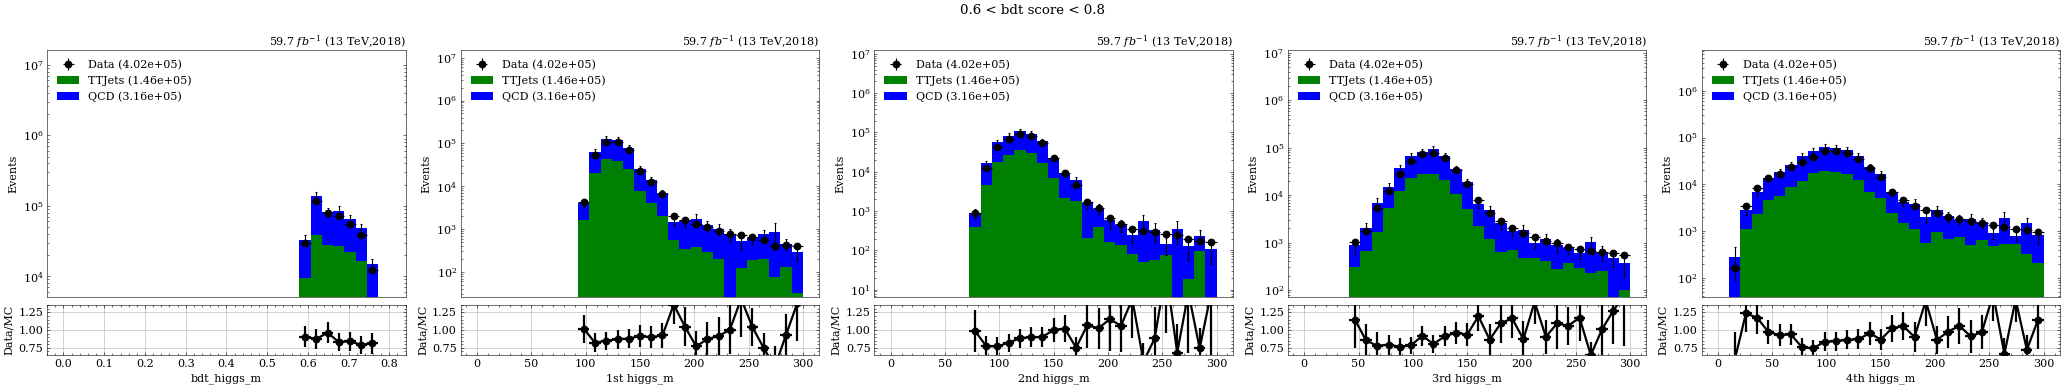

In [20]:
for i, (lo,hi) in enumerate(zip([0.,0.2,0.4,0.6],[0.2,0.4,0.6,0.8])):
    study.quick(
        data+bkg, log=True, dim=-1, legend=True,
        masks=lambda t: blind_mask(t)&(t.bdt_higgs_m>lo)&(t.bdt_higgs_m<hi),
        varlist=['bdt_higgs_m']+[f'higgs_m[:,{j}]' for j in range(4)],
        binlist=[(0,0.8,30)]+[(0,300,30)]*4, 
        suptitle=f'{lo} < bdt score < {hi}',
        **study.datamc
    )
    

## Good agreement (within reason) between Data and MC

# Validation Region

100%|██████████| 1/1 [00:03<00:00,  3.15s/it]


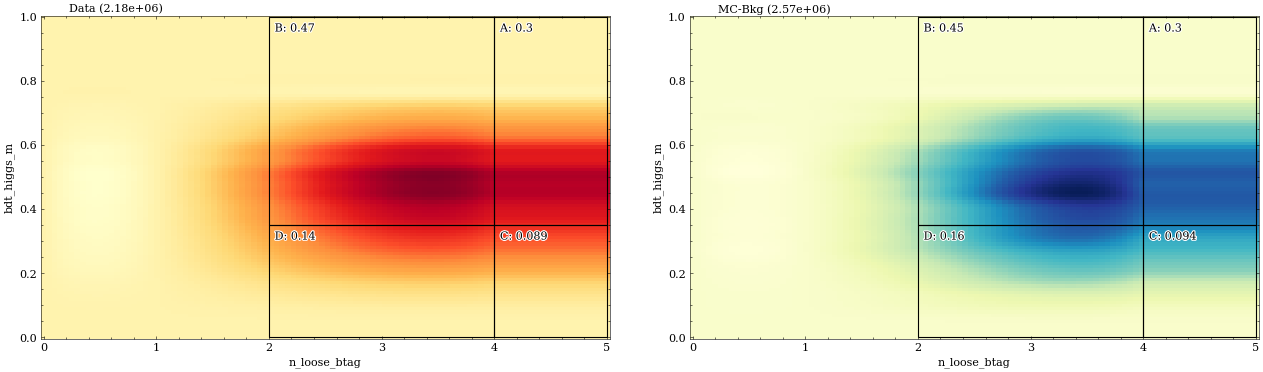

In [21]:
study.quick2d(
    data+bkg,
    masks=blind_mask,
    varlist=['n_loose_btag','bdt_higgs_m'],
    interp=True,
    exe=draw_abcd(x_r=(2,4,5),y_r=(0.,0.35,1.0))
)

In [22]:
vr_bdt = ABCD(
    features=['X_m','X_pt'],
    a=lambda t : (t.n_loose_btag == 4) &                         (t.bdt_higgs_m > 0.35),
    b=lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag <  4) & (t.bdt_higgs_m > 0.35),
    c=lambda t : (t.n_loose_btag == 4) &                         (t.bdt_higgs_m < 0.35),
    d=lambda t : (t.n_loose_btag >= 2) & (t.n_loose_btag <  4) & (t.bdt_higgs_m < 0.35),
)

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


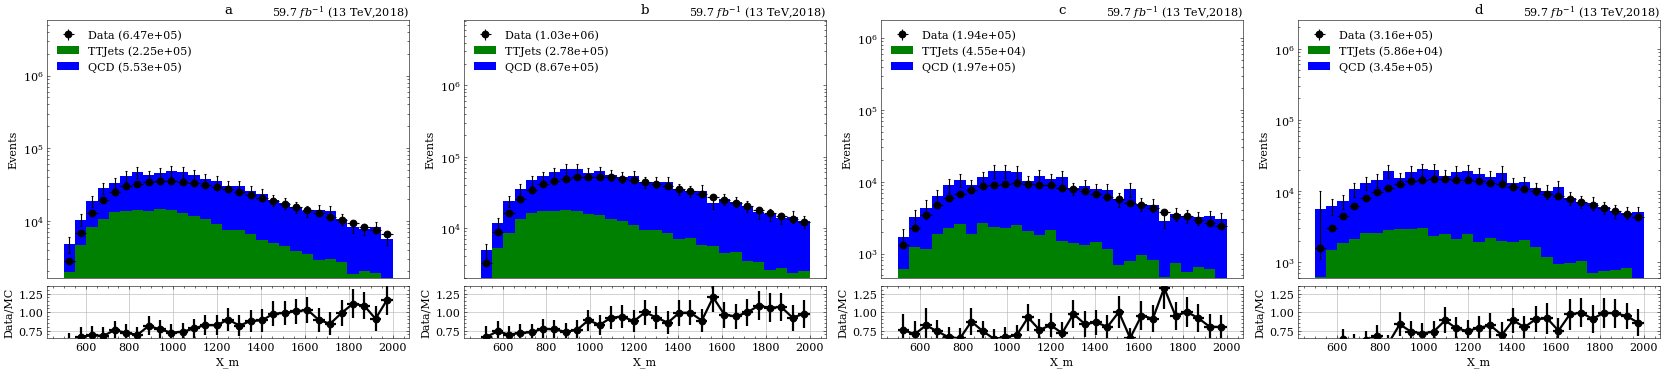

In [23]:
fig,axs=study.get_figax(4, dim=-1)
for i,region in enumerate(('a','b','c','d')):
    study.quick(
        data+bkg, legend=True, log=True,
        masks=getattr(vr_bdt, region),
        varlist=['X_m'],
        title=region,
        **study.datamc,
        figax=(fig, axs.flat[i])
    )

# Train BDT on data 

In [24]:
vr_bdt.train(data)
vr_bdt.print_results(data)

--- ABCD Results ---
k = 6.130e-01
k*(b/a)-1  = -2.86%
BDT(b)/a-1 = -2.10%



In [28]:
bkg_model = data.copy()
for tree in bkg_model:
    tree.is_model = True

In [31]:
study.kstest['e_show'] = False

100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


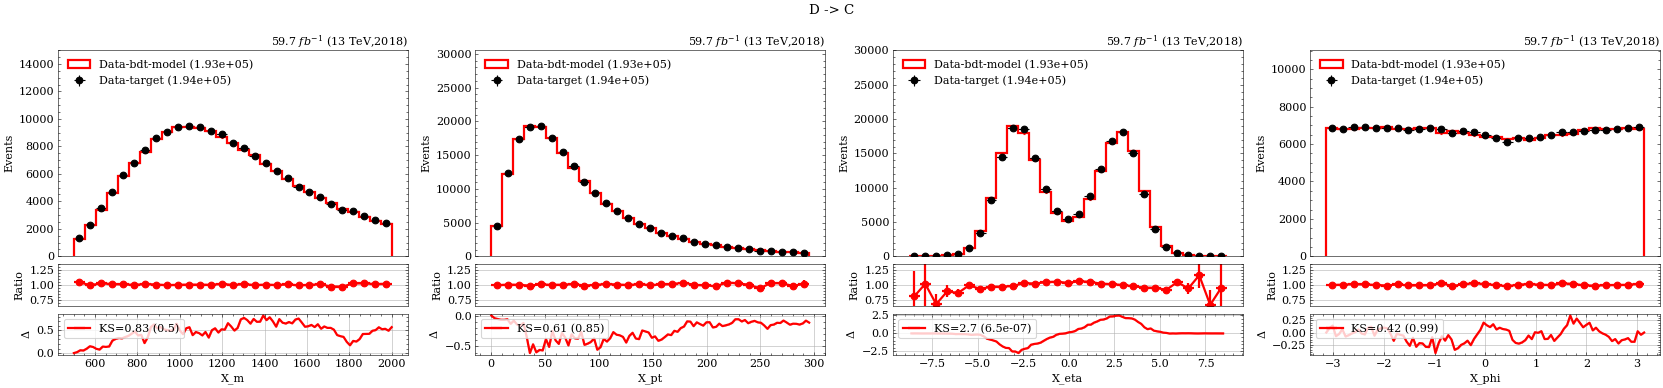

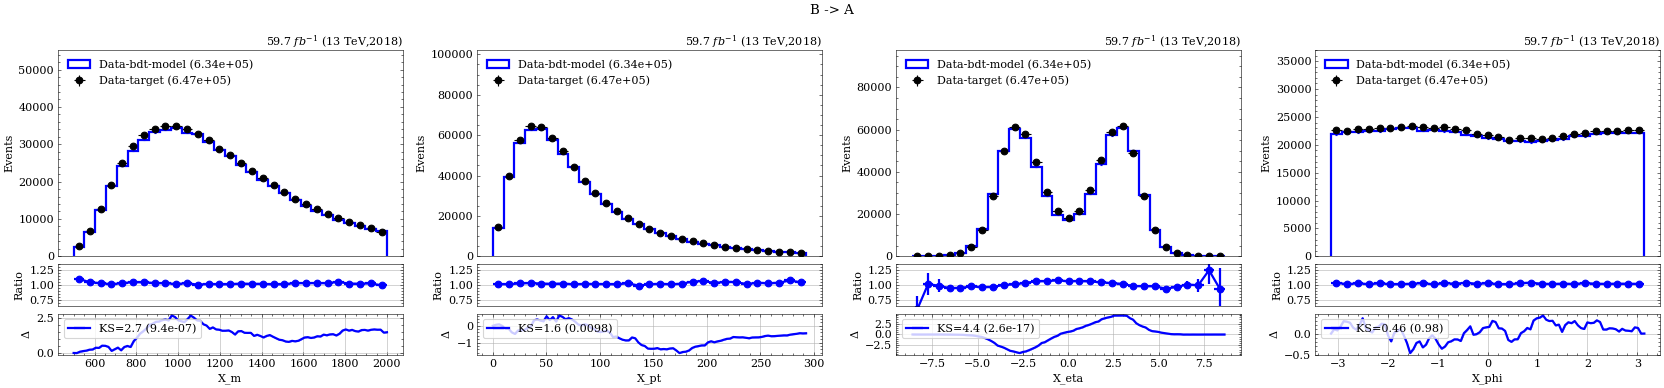

In [32]:
study.quick_region(
    data, bkg_model, legend=True, 
    h_color=['grey','red'],
    dim=-1,
    label=['Data-target','Data-bdt-model'],
    masks=[vr_bdt.c]*len(data)+[vr_bdt.d]*len(data),
    scale=[1]*len(data)+[vr_bdt.reweight_tree]*len(data),
    varlist=['X_m', 'X_pt','X_eta','X_phi'],
    ratio=True, r_ylim=(0.65,1.35),
    **study.kstest,

    suptitle='D -> C'
)

study.quick_region(
    data, bkg_model, legend=True, 
    h_color=['black','blue'],
    dim=-1,
    label=['Data-target','Data-bdt-model'],
    masks=[vr_bdt.a]*len(data)+[vr_bdt.b]*len(data),
    scale=[1]*len(data)+[vr_bdt.reweight_tree]*len(data),
    varlist=['X_m', 'X_pt','X_eta','X_phi'],
    ratio=True, r_ylim=(0.65,1.35),
    **study.kstest,

    suptitle='B -> A'
)

# Conclusions
## Data/Model agree very well!
## KS test fails though. I believe this is because with the added statstics, the KS test becomes stricter in the allowed differences between the distributions 